<a id="top"></a>
# Cloud Statistics

<hr>

# Notebook Summary

This notebook explores Landsat Data and reports cloud statistics 
for selected regions for a selected time period. This is valuable information for performing analyses. 
For example, if there are extensive clouds for a season it may significantly impact the 
mosaic product or index values. Another example is that a user may want to find a single 
date when there are few clouds to assess land features.

<hr>

# Index

* [Import Dependencies and Connect to the Data Cube](#import)
* [Define the Extents of the Analysis](#define_extents)
* [Load the Data](#define)
* [Create the CLoud mask](#define)
* [Calculate the Cloud Coverage Percentage for Each Pixel](#calc_cloud_coverage)
* [Create a Table of Cloud Coverage Percentage for Each Date](#create_cloud_cov_table)
* [Create a Plot of Cloud Coverage Percentage for Each Date](#plot_cloud_cov)
* [Create an Image of the Percent of Clear Views Per Pixel for the Entire Time Period](#pct_clear_img)
* [Review an RGB Scene for a Selected Time Slice](#rgb_time_slice)

## <span id="import">Import Dependencies and Connect to the Data Cube [&#9652;](#top)</span> 

In [2]:
# Load Data Cube Configuration
import datacube
import sys
import os

# Supress Warnings.
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
from odc.ui import DcViewer
from datacube.helpers import write_geotiff
from datacube.storage.masking import make_mask


#import DE Africa script
sys.path.append('../Scripts')
from deafrica_plotting import display_map
from deafrica_plotting import rgb


#import DCAL utility scripts
sys.path.append('../DCAL_utils')
#from dc_load import load_multiplatform

In [3]:
dc = datacube.Datacube(app="DCAL Cloud Statistics")

## <span id="define_extents">Define the Extents of the Analysis [&#9652;](#top)</span>

<p style="color:red";><b>CHANGE INPUTS BELOW

In [4]:
# Select an analysis region (Lat-Lon) within the extents listed above. 
# Select a time period (Min-Max) within the extents listed above (Year-Month-Day)
# This region and time period will be used for the cloud assessment


latitude = 1.1428
longitude = 34.5565
buffer = 0.10

x=(longitude-buffer, longitude+buffer)
y=(latitude+buffer, latitude-buffer)

# Time Period
time_extents = ('2014-01-01', '2014-12-31')

**Visualize the selected area**

In [5]:
display_map(x,y)

#click anywhere on map to see Latitude and Longitude for that point

## Load the dataset

In [6]:
landsat_dataset = dc.load(product = 'ls8_usgs_sr_scene',
                          measurements = ['red', 'green', 'blue', 'pixel_qa'],
                          y = y,
                          x = x,
                          time = time_extents,
                          output_crs='EPSG:6933',
                          resolution=(-30,30))

## Create cloud mask

In [7]:
#set which quality flags we want to use
quality_flags = {'cloud': 'no_cloud',
                 'cloud_shadow': 'no_cloud_shadow',
                 'nodata': False}

#create cloud mask
Cloud_mask = make_mask(landsat_dataset.pixel_qa, **quality_flags)
             

In [8]:
Cloud_mask

<xarray.DataArray 'pixel_qa' (time: 41, y: 851, x: 644)>
array([[[False, False, ..., False, False],
        [False, False, ..., False, False],
        ...,
        [False, False, ..., False, False],
        [False, False, ..., False, False]],

       [[False, False, ...,  True,  True],
        [False, False, ...,  True,  True],
        ...,
        [False, False, ...,  True,  True],
        [False, False, ...,  True,  True]],

       ...,

       [[False, False, ..., False, False],
        [False, False, ..., False, False],
        ...,
        [False, False, ...,  True,  True],
        [False, False, ...,  True,  True]],

       [[False, False, ..., False, False],
        [False, False, ..., False, False],
        ...,
        [False, False, ..., False, False],
        [False, False, ..., False, False]]])
Coordinates:
  * time     (time) datetime64[ns] 2014-01-16T07:56:17.589047 ... 2014-12-18T07:55:16.217103
  * y        (y) float64 1.585e+05 1.585e+05 1.585e+05 ... 1.331e+05 1.33e+0

## Calculate the Cloud Coverage Percentage for Each Pixel

In [9]:
#create list of observation dates
times = list(landsat_dataset.time.values)

#create list of scenes
scene_slice_list = list(map(lambda t: landsat_dataset.sel(time = t), times))

#Find where each pixle is clear
clean_mask_list = [Cloud_mask.sel(time=time).values for time in Cloud_mask.time]

# Calculate the percentage of observation which are not cloud.
percentage_list = [int(Cloud_mask.mean()*100) for Cloud_mask in clean_mask_list]
clean_pixel_count_list = list(map(np.sum, clean_mask_list))

data = {"times": times,
        "clean_percentage": percentage_list,
        "clean_count": clean_pixel_count_list }
    
coverage_table = pd.DataFrame(data=data, columns = ["times", "clean_percentage", "clean_count"])


## <span id="create_cloud_cov_table">Create a Table of Cloud Coverage Percentage for Each Date[&#9652;](#top)</span>

In [10]:
pd.set_option('display.max_rows', len(coverage_table))
coverage_table

,times,clean_percentage,clean_count
0,2014-01-16 07:56:17.589047,0,0
1,2014-02-01 07:55:48.585163,44,245668
2,2014-02-01 07:56:12.501616,0,0
3,2014-02-17 07:55:34.683713,9,53341
4,2014-02-17 07:55:58.595930,0,0
5,2014-03-05 07:55:19.082570,83,460059
6,2014-03-05 07:55:42.999023,0,0
7,2014-03-21 07:55:09.302064,61,334596
8,2014-03-21 07:55:33.218517,0,0
9,2014-04-06 07:54:54.337306,26,144349


## <span id="plot_cloud_cov">Create a Plot of Cloud Coverage Percentage for Each Date[&#9652;](#top)</span>

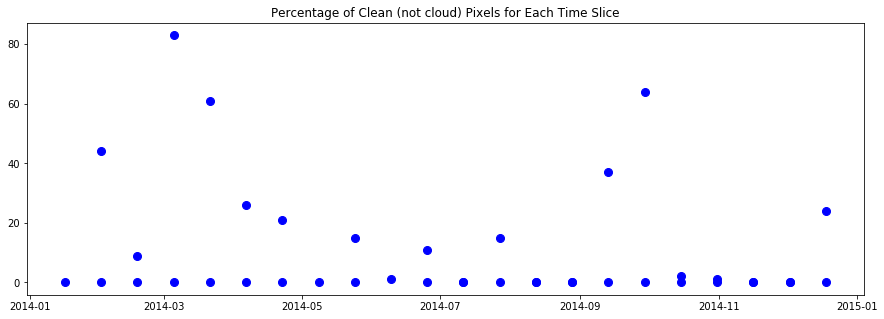

In [11]:
plt.figure(figsize = (15,5))
plt.plot(coverage_table["times"].values, coverage_table["clean_percentage"].values, 'bo', markersize=8)
plt.title("Percentage of Clean (not cloud) Pixels for Each Time Slice")
plt.show()

## <span id="pct_clear_img">Create an Image of the Percent of Clear Views Per Pixel for the Entire Time Period[&#9652;](#top)</span>

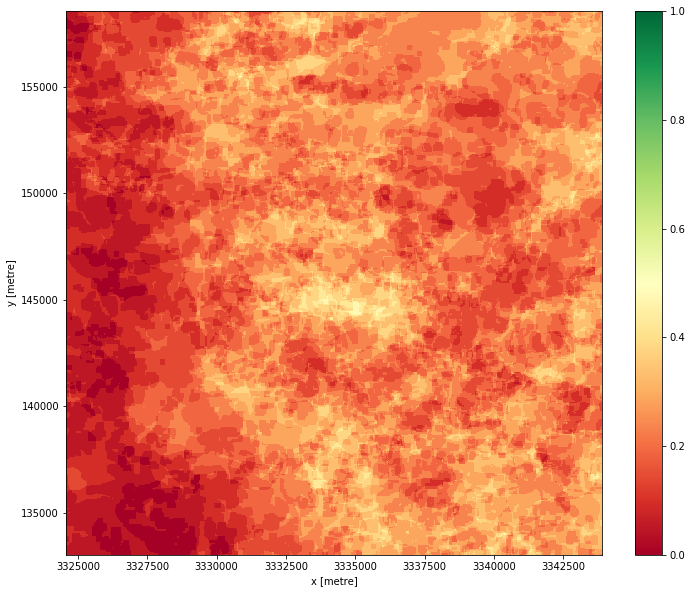

In [12]:
# We are really plotting the fraction of times that are not no_data which are clear.
# This is done to account for regions filled with no_data  - such as when querying across path/rows.

# find where unmasked landsat in NOT no-data
data_mask = (landsat_dataset['red'] != -9999)

#find where no-data mask and could mask overlap
merged_mask = Cloud_mask & data_mask
clear_and_data_per_px = merged_mask.sum(dim='time')
data_per_px = data_mask.sum(dim='time')
frac_clear_per_data_per_px = clear_and_data_per_px / data_per_px
num_cbar_ticks = 8 # The number of ticks to use for the colorbar.
quad_mesh = (frac_clear_per_data_per_px).plot(figsize=(12,10),cmap = "RdYlGn", vmin=0, vmax=1)
plt.show()

In [13]:
print("Percent of pixels with data: {:.2%}".format(data_mask.mean().values))
print("Percent of pixels that are clear: {:.2%}".format(Cloud_mask.mean().values))
print("Percent of pixels that are clear and have data: {:.2%}".format(merged_mask.mean().values))

Percent of pixels with data: 51.22%
Percent of pixels that are clear: 10.31%
Percent of pixels that are clear and have data: 10.31%


In [14]:
(frac_clear_per_data_per_px == 0).sum() / frac_clear_per_data_per_px.count()
print("Number of pixels which have no non-cloud data:", (frac_clear_per_data_per_px == 0).sum().values)
print("Total number of pixels:", frac_clear_per_data_per_px.count().values)

Number of pixels which have no non-cloud data: 15456
Total number of pixels: 548044


## <span id="rgb_time_slice">Review an RGB Scene for a Selected Time Slice[&#9652;](#top)</span>

In [15]:
#apply Cloud mask to Landsat data
masked_landsat_dataset = landsat_dataset.where(merged_mask)

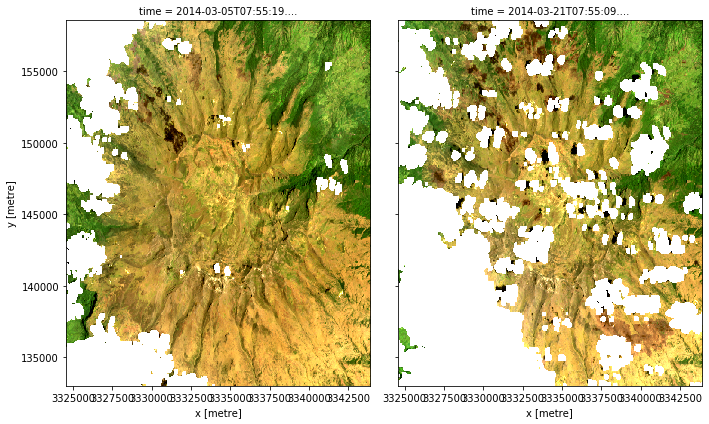

In [16]:
rgb(masked_landsat_dataset, index=[5,7])

## Notes on modifications made moving from ARDC to DE Africa

- Pulled appart  build_cloud_coverage_table_landsat fuction in-order to rebuild using DE Africa dc.load and datacube.storage.masking make_mask fuction
- Move all module imports to start of notebook
- Removed code to view extent of datacube replaced with mapviewer that can be used to visualise spatial extent of data
- Changed rgb plot fuction to DE Africa rgb plot fuction
